In [2]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numba import jit
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize, root_scalar
from pynndescent import NNDescent
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA

In [120]:
def exp_k(dists, sigma):
    return np.exp(- (dists - dists[0]) / sigma).sum()

In [121]:
def find_sigma(d, k, lower_bound=1e-6, upper_bound=1e6):
    return root_scalar(
        lambda s: exp_k(d, s) - np.log2(k),
        bracket=(lower_bound, upper_bound)
    ).root

In [186]:
def w_ij_sym(x, k, verbose=False):
    num_pts = x.shape[0]
    if verbose:
        print('Indexing')
    index = NNDescent(x)
    neighbors = np.empty((num_pts, k), dtype=np.int)
    w_ij = np.empty((num_pts, k))
    for i, xi in enumerate(x):
        if verbose:
            print('Calculating probabilities: {cur}/{tot}'.format(
                cur=i+1, tot=num_pts), end='\r')
        nn, dists = index.query([xi], k+1)
        sigma = find_sigma(dists[0, 1:], k)
        neighbors[i] = nn[0, 1:]
        w_ij[i] = np.exp(- (dists[0, 1:] - dists[0, 1]) / sigma)
    row_indices = np.repeat(np.arange(num_pts), k)
    w = csr_matrix((w_ij.ravel(), (row_indices, neighbors.ravel())))
    return w + w.transpose() - (w.multiply(w.transpose()))

In [ ]:
def attractive(y1, y2, w, a, b):
    # implement

In [ ]:
def repulsive(y1, y2, w, a, eps):
    #implement

In [187]:
test = np.array([[-3.06171, -4.11811, -4.14201], [-3.48205, -3.61966, -4.11191], \
[-3.39921, -3.87553, -3.29049], [-4.68813, -4.0472, -4.12214], \
[-3.48713, -3.14269, -4.34275], [-4.51038, -4.00394, -4.3596], \
[-3.13714, -4.13327, -4.51051], [-4.19964, -4.53911, -4.23953], \
[-4.95219, -3.96263, -3.89572], [-3.35954, -4.70329, -3.07582], \
[-3.2119, -4.96839, -3.08038], [-3.24371, -3.83312, -3.61483], \
[-3.40949, -4.45078, -3.78719], [-3.09332, -3.79775, -3.46667], \
[-4.91732, -3.88528, -4.61838], [-3.15103, -3.91748, -4.36707], \
[-4.42049, -4.71466, -3.07121], [-4.74834, -4.03872, -3.34], \
[-3.86279, -4.38292, -4.1312], [-3.88534, -4.31399, -4.52699], \
[-4.96182, -4.47331, -4.41101], [-3.6295, -3.54756, -4.34747], \
[-4.83112, -3.35922, -4.122], [-3.08844, -4.75231, -4.85078], \
[-3.30012, -4.86028, -4.86922], [-3.49449, -3.01869, -3.45126], \
[-3.61592, -4.68816, -4.89749], [-4.63409, -4.0591, -4.21579], \
[-4.40304, -4.71147, -3.07672], [-4.61355, -4.31953, -4.56348], \
[-4.0648, -3.57047, -3.63491], [-4.02017, -4.3035, -3.7841], \
[-4.62434, -3.90364, -4.90268], [-3.13517, -3.52685, -3.46153], \
[-4.73968, -3.46959, -4.30312], [-4.45781, -4.45373, -3.90877], \
[-3.64275, -4.55513, -3.19545], [-3.82554, -4.69118, -4.86266], \
[-3.41763, -4.08769, -3.28228], [-4.42859, -4.06743, -3.27181], \
[-0.84458, -0.253462, 0.676612], [0.833637, -0.642775, 0.121626], \
[0.448482, -0.415658, 0.603946], [0.036695, -0.532071, -0.700668], \
[-0.325666, -0.543704, 0.788904], [0.989751, 0.671218, 0.0132128], \
[-0.447015, -0.170782, -0.496506], [-0.715256, -0.321029, 0.550715], \
[0.743418, -0.240408, -0.17556], [-0.595065, -0.93854, -0.746602], \
[0.495365, 0.325908, -0.414435], [-0.311924, 0.683907, 0.740203], \
[0.383382, -0.299211, -0.375763], [0.284666, -0.233734, -0.894192], \
[-0.295091, 0.242352, 0.606325], [0.277676, -0.0578679, 0.361655], \
[-0.0552429, 0.374057, 0.382518], [-0.080685, -0.486527, -0.0462675], \
[0.552634, -0.661948, -0.196819], [-0.438172, -0.312995, 0.974798], \
[-0.779359, 0.076314, 0.292763], [-0.121777, 0.362385, -0.893189], \
[-0.994044, 0.215208, -0.489444], [0.479027, 0.65953, -0.519253], \
[0.485033, 0.448242, -0.205784], [0.92543, -0.954904, -0.832041], \
[-0.66871, -0.812729, -0.750999], [-0.0113451, 0.869197, 0.492122], \
[0.0420333, -0.501131, 0.416016], [-0.462631, 0.825023, 0.883584], \
[0.622358, -0.244562, 0.246466], [0.863388, -0.729517, 0.750641], \
[-0.574346, -0.478874, 0.175001], [0.699988, 0.278915, -0.514162], \
[0.441992, 0.651797, -0.519486], [-0.341418, 0.815244, 0.709427], \
[-0.33556, -0.314244, 0.312021], [-0.291649, -0.524048, -0.753128], \
[-0.879061, 0.771564, -0.320758], [0.633937, -0.852491, -0.724415], \
[4.26158, 3.7156, 3.47227], [3.54413, 4.91863, 3.09096], [3.72428, \
3.33377, 3.57807], [4.06755, 4.71954, 3.99237], [3.7346, 4.47583, \
3.85198], [4.079, 4.59723, 4.58943], [4.61415, 3.03375, 4.18271], \
[3.46713, 3.79068, 4.96112], [4.25852, 4.00672, 3.00557], [4.75162, \
4.49518, 3.36331], [4.2122, 3.33913, 3.79177], [3.65181, 3.91682, \
3.68722], [3.66843, 3.78445, 4.24208], [3.89142, 4.7451, 4.46761], \
[3.35725, 4.34459, 4.99383], [3.97371, 4.43093, 3.8621], [3.72445, \
4.13716, 3.65663], [3.02038, 3.75441, 4.8097], [4.21777, 4.34144, \
3.48594], [4.03024, 3.75258, 3.62263], [4.68306, 3.82172, 3.49328], \
[4.7987, 4.0906, 4.64184], [4.33042, 4.69867, 3.31606], [3.43534, \
4.09571, 3.87918], [3.65397, 3.57712, 4.05887], [3.96006, 4.32792, \
4.43532], [3.93925, 4.20241, 3.86351], [4.92339, 3.13164, 3.61859], \
[4.60501, 4.63458, 3.85957], [4.71184, 4.11839, 4.48845], [4.10771, \
4.28559, 3.33411], [3.66739, 3.93157, 3.08225], [3.21379, 4.9739, \
3.34205], [3.32057, 3.51715, 3.11003], [3.3738, 4.36305, 3.87897], \
[4.08336, 3.17929, 3.81939], [3.49949, 4.68424, 4.22113], [4.21128, \
3.76637, 4.4221], [4.16039, 3.54649, 4.80044], [4.78542, 3.07074, \
3.63592]])

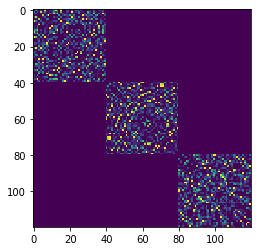

In [191]:
plt.imshow(w_ij_sym(test,20).toarray())